In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from functools import reduce
from numba import jit
import networkx as nx

%precision 5

'%.5f'

## TASK 1

In [2]:
df=pd.read_csv("bci05.csv", usecols=['sp','status','gx','gy'])  #elimino colonne inutili
df=df[df['status']=='A']    #tengo solo i vivi
df.drop('status', axis=1, inplace=True)   #elimino colonna vivi/morti

In [3]:
# to show the dataframe uncomment the following line:
df

,sp,gx,gy
0,ACACME,610.0,104.7
1,ACACME,534.8,241.3
4,ACACME,282.7,177.5
5,ACACME,84.2,74.8
6,ACACME,149.9,389.8
7,ACACME,450.8,216.8
8,ACACME,606.4,105.6
9,ACACME,606.1,103.1
10,ACACME,606.3,102.4
11,ACACME,612.6,107.6


In [5]:
# counting the total number of species
number_species=df['sp'].nunique()
print('The total number of species is: ', number_species)

The total number of species is:  299


In [6]:
# renaming spiecies with their number
species = np.unique(df['sp'])
df = df.replace({'sp':dict(zip(species, np.arange(number_species)) ) }) 

## TASK 2

In [7]:
# dividing in 200 zones and creating a dataframe for every subplot
def subplotter(n, xdim=50, ydim=50):
    
    nx=n%(1000/xdim)                  #coordinata cella orizzontale scelta (da 0 a 1000/xdim-1)
    ny=n//(1000/xdim)                 #coordinata cella verticale scelta (da 0 a 500/ydim-1)

    #print(nx, ny)
    
    return df[(xdim*nx<=df['gx']) & (df['gx'] < xdim*(nx+1) ) & 
              (ydim*ny<=df['gy']) & (df['gy']<(ny+1)*ydim)]


In [8]:
#controllo siano tutte comprese

c=0
for i in range(200):
    c+=len(subplotter(i))
    
c==len(df)

True

In [9]:
#creo una lista contenente ciascun dataframe che rappresenta un diverso subplot
#nel quale vengono contate le volte che compare una certa specie

sub=[i for i in range(201)] #inizializzo la lista
sub[0]=pd.DataFrame(np.zeros(number_species)).rename(index=str, columns={0:'00'}) #indispenabile per mantenere tutti gli indici nel dataframe finale (joint infatti costruisce basandosi sul parametro how=left)

for i in range(200):
    # subplotter gives the species (renamed with a progressive number in the previous cells),
    # subplotter.sp.value_counts() gives the number of individuals of that species (sorted in descending order)
    # pd.DataFrame.sort_index(...) sort the content w.r.t. the index, so in our case the
    #     subplotter.sp.value_counts() is re-ordered by index, and so by species, and not in
    #     based on the frequancy of the species
    # pd.Dataframe(...).rename(...{'sp':i}) rename the column of the current DataFrame (which
    #     is called 'sp' and it is no more useful because now we want the subplot information)
    #     with the subplot number
    # all this stuff is saved at position i+1 of 'sub'
    sub[i+1]=pd.DataFrame(pd.DataFrame.sort_index((subplotter(i).sp.value_counts()))).rename(index=str, columns={'sp':i})   #conto esemplari di stess specie nel dataframe
    


In [10]:
#concateno i dataframe creati 

# reduce is a function that acts recursively on the list given
vectors=reduce(lambda x, y: pd.DataFrame.join(x,y), sub)

# Filling nan with 0s (python places "nan" to fill "void" positions when adding)
vectors.fillna(0, inplace=True)
# eliminating first column: it was used to assure that all the species were present every time we
#     added a plot in sub all species was present (python gives "nan" to fill void positions when adding)
vectors.drop('00',axis=1,inplace=True)
# renaming dataframe columns
vectors.rename_axis("species", inplace=True)
vectors.rename_axis("subplot", axis="columns", inplace=True)

# to show the matrix of subplots and their content uncomment the following line
#vectors

In [11]:
#faccio le medie per ogni specie sul numero di subplot (presenza media)

#average_presence=pd.DataFrame(vectors.mean(axis=1))

#faccio la media delle presenze nei subplot di ciascuna specie
average_presence=np.zeros(299)
for i in range(299):
    average_presence[i]=np.count_nonzero(vectors.iloc[i])/200

# trasforming to dataframe
average_presence=pd.DataFrame(average_presence)

average_presence.rename(index=str, columns={0:'average presence p'}, inplace=True)

# to show the vector of the average presence uncomment the following line
#average_presence

## TASK 3

The probability given by the max-entropy principle is given by:
$$ P(\vec{\sigma})=\frac{1}{Z}e^{-\sum_{i=1}^S \lambda_i \sigma_i} $$

Then, the partition function is the following:
$$ Z = 2^S \prod_{i=1}^S \cosh(\lambda_i) $$

The theoretical average is:
$$ m_j = \langle \sigma_j \rangle_{model} = -\frac{\partial \log(Z)}{\partial \lambda_j}=-\tanh(\lambda_j) \implies \lambda_j = - \tanh^{-1}(m_j) $$

Inserting this in the partition function we obtain:
$$ Z=2^S \prod_{i=1}^S \cosh \left( \tanh^{-1} \lambda_i \right) $$

In [ ]:
### evaluating the "magnetization"
magn_sper=np.array(average_presence['average presence p'])*2-1
plt.figure(figsize=(10,10))
plt.plot(np.arange(number_species),magn_sper, label='Magnetization')
plt.ylim(-1.25, 1.25)
plt.xlabel('Species')
plt.ylabel('Magnetiztion')
plt.legend()
plt.show()

print("The species that are present in every plot are:", np.where(magn_sper==1))

In [13]:
# evaluating λ coefficients
lambda_=np.arctanh(magn_sper)
lambda1=pd.DataFrame(lambda_).rename(index=str, columns={0:'$\lambda$'}).rename_axis("species")


# to show the λ coefficients uncomment the following line
#lambda1

/home/tommaso/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in arctanh
  


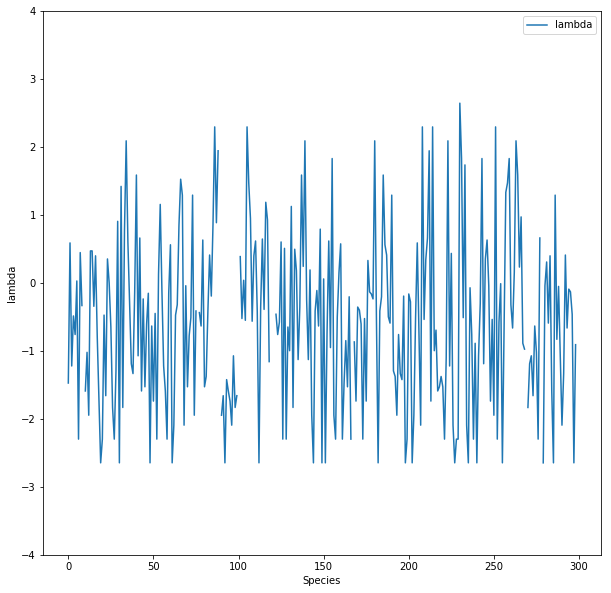

In [14]:
# plotting λs
plt.figure(figsize=(10,10))
plt.plot(np.arange(number_species),lambda1, label='lambda')
plt.xlabel('Species')
plt.ylabel('lambda')
plt.ylim(-4, 4)
plt.legend()
plt.show()

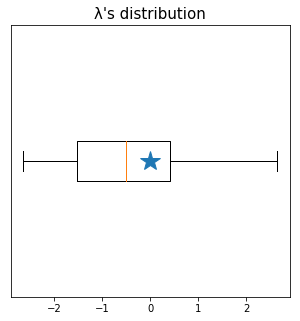

In [128]:
fig1, (ax1) = plt.subplots(figsize=(5, 5))

ax1.boxplot(np.array(lambda1.values), vert = False)

ax1.plot( 0, 1, marker='*', markersize=20 )

ax1.set_title('λ\'s distribution', fontsize=15)
ax1.set_yticks([])

            
plt.show()

## TASK 4

### Starting to implement Metropolis

In [16]:
# evaluating the constraint: <(S+ - S-)²>
sp_sm=0

for i in range(200):
    s_p=np.count_nonzero(vectors[i])
    s_m=299-s_p
    sp_sm+=(s_p-s_m)**2

sp_sm=sp_sm/200
sp_sm

6377.16000

In [17]:
@jit
def energy(λ, K, configuration):
    return -np.sum(λ*configuration)-K/(len(configuration))*np.sum(configuration)**2
    #return -np.sum(λ*configuration)-K*np.sum(configuration)**2

# Defining metropolis functions to generate some configurations:
# Parameters are:
# - λ      = vectors of coefficients
# - number = number of configurations to be generated
# - dim    = number of spins in x dimension

# N.B.: λ parameter should have the same dimension of dimx*dimy because it represents
#       local fields for every σ_i

@jit
def metropolis_sample(λ, K, number=30000, dim=299)
    config_list = np.zeros(shape=(number,dim))
    energy_list = np.zeros(number)

    # starting from a random configuration
    config = np.random.randint(low=0, high=2, size=dim)
    # replacing 0 with -1
    config[config==0] = -1
    cont = 0
    while cont < number:
        # choosing new config
        new_config = config.copy()
        new_config[np.random.randint(0, dim)] *= (-1)
        # N.B.: CONVENTIONALLY, β=1
        β = 1
        energy_list[cont] = energy(λ, K, config)
        δE = energy(λ, K, new_config) - energy(λ, K, config)
        prob_change = min(1, np.exp( -β*δE ))

        #if prob_change != 1:
        if np.random.uniform(0, 1)<prob_change:
            config = new_config.copy()
        #else:
        #    config = new_config.copy()

        config_list[cont] = config
        cont+=1
    #return [config_list, energy_list]
    return [config_list[int(-number/5):], energy_list[int(-number/5):]]

In [18]:
# using previous λ to initialize the algorithm (we are changing the +∞)
λ_0 = lambda1.values.copy()
λ_0[np.isinf(λ_0)] = 10000
λ_0 = λ_0.T[0]

# uncomment the following line to show the vector of λ_0 just created
#print(λ_0)

In [19]:
# defyning ADAMS algorithm (a different algorithm for gradient descent)
def ADAMS(λ, K, g, m, s, g1, s1, m1, t, β1=0.9, β2=0.99, ε=10**(-8), η=10**(-3)):
    m = β1*m + (1-β1)*g
    s = β2*s + (1-β2)*g**2
    m_avg = m/(1-β1**t)
    s_avg = s/(1-β2**t)
    λ = λ - η*m_avg/((s_avg)**(1/2)+ε)
    
    m1 = β1*m1 + (1-β1)*g1
    s1 = β2*s1 + (1-β2)*g1**2
    m1_avg = m1/(1-β1**t)
    s1_avg = s1/(1-β2**t)
    K = K - η*m1_avg/((s1_avg)**(1/2)+ε)
    
    return λ, K, g, g1, m, m1, s, s1

In [20]:
# Chose random λ
# Can not initialize with previous vector of λ because some of them are inf
#λ_0 = lambda1.values
#λ_0[np.isinf(λ_0)] = 1000
λ_0 = λ_0.T[0]
# Choosing random λ
#λ_0 = np.random.normal(0, 1, size=299)
#λ_0 = np.zeros(299)

# Initializing K at 0.5 (arbitrary choice)
#K = 0.0
K = 0.5

# recalling constraints
constr_λ = 2*average_presence.values.T[0]-1
constr_K = sp_sm/299

# Creating list of configurations
dim_sample = 10
config_list = np.zeros(shape=(dim_sample, 299))
n_iter=2000

saveK=np.zeros(100)
saveλ_0=np.zeros(shape=(100, 299))

### Here there should be a iteration
for i in range(1, n_iter):
    
    # Sample with metropolis
    
    #for num in range(dim_sample):
    config_list = metropolis_sample(λ_0, K, dim=299, number=30000)[0]

    #plt.plot(results_list[1])
    #plt.show()

    # Updating λs
    # Evaluating new theoretical constraints
    constr_theo_λ = np.zeros(299)
    constr_theo_K = 0
    # updating elementwise
    for conf in config_list:
        constr_theo_λ += conf
        constr_theo_K += ((np.sum(conf))**2)
    constr_theo_λ /= len(config_list)
    constr_theo_K = constr_theo_K/(len(config_list)*299)

    η = 0.01

    #λ_0 = λ_0 + η*(constr_λ - constr_theo_λ)
    #K = K + η*(constr_K - constr_theo_K)
    g = -(constr_λ - constr_theo_λ)
    g1 = -(constr_K - constr_theo_K)
    m = 0
    m1 = 0
    s = 0
    s1 = 0
    
    λ_0, K, g, g1, m, m1, s, s1 = ADAMS(λ_0, K, g, m, s, g1, s1, m1, t=i, η=η)

    if n_iter-i<100:
        saveλ_0[n_iter-i]=λ_0
        saveK[n_iter-i]=K
      
    if (i%50==0):
        print("\nIteration n.: " + str(i+1))
        print("constr λ_theo:\n", constr_theo_λ[:10])
        print("λ_updated:\n", λ_0[:10])
        print("constr K_theo:", constr_theo_K)
        print("Constr K sperim:", constr_K)
        print("K_updated:\n", K, end="\n\n")
        #print(conf)
        print("Number of 'spin' +1 is:", len(conf[conf==1]))
        #plt.plot(results_list)
        plt.show()


Iteration n.: 51
constr λ_theo:
 [-1.      -0.88167 -0.815   -0.83467 -1.      -0.94067 -1.      -0.84333
 -0.67367 -0.89267]
λ_updated:
 [-1.28728 -1.19697 -1.26566 -1.20923 -1.19697 -1.19697 -1.32737 -1.19697
 -1.19697 -1.19697]
constr K_theo: 258.34577926421406
Constr K sperim: 21.32829431438127
K_updated:
 0.2247500388867945

Number of 'spin' +1 is: 9

Iteration n.: 101
constr λ_theo:
 [-0.547   -0.489   -0.82033 -0.74467 -0.533   -0.53367 -1.      -0.00833
 -0.65733 -0.80367]
λ_updated:
 [-1.29394 -0.83453 -1.13816 -0.87675 -0.99853 -0.83453 -1.43544 -0.83453
 -0.83453 -0.83453]
constr K_theo: 142.97907246376812
Constr K sperim: 21.32829431438127
K_updated:
 -0.1376926204289722

Number of 'spin' +1 is: 63

Iteration n.: 151
constr λ_theo:
 [-0.865    0.38267 -0.279    0.018   -0.81633 -0.08233 -0.88233 -0.16367
 -0.58333  0.23933]
λ_updated:
 [-1.49682 -0.41229 -1.29128 -0.8294  -1.03188 -0.5155  -1.70554 -0.41229
 -0.719   -0.41229]
constr K_theo: 52.98656856187291
Constr K sper


Iteration n.: 1201
constr λ_theo:
 [-1.       0.792   -0.73933 -0.22833 -0.312    0.15833 -1.       0.37833
 -0.011    1.     ]
λ_updated:
 [-1.06909  0.86907 -0.8244  -0.1711  -0.389    0.31732 -1.32856  0.65821
 -0.04809  2.82085]
constr K_theo: 13.68923076923077
Constr K sperim: 21.32829431438127
K_updated:
 0.5779153873675738

Number of 'spin' +1 is: 113

Iteration n.: 1251
constr λ_theo:
 [-0.33867  0.495   -0.594   -0.10967 -0.13267 -0.01167 -1.       0.598
 -0.50733  1.     ]
λ_updated:
 [-0.96909  0.82907 -0.8844  -0.0811  -0.409    0.29733 -1.36856  0.77821
  0.03191  2.88085]
constr K_theo: 24.32485618729097
Constr K sperim: 21.32829431438127
K_updated:
 0.6379153172833885

Number of 'spin' +1 is: 105

Iteration n.: 1301
constr λ_theo:
 [-1.       0.37067 -1.      -0.59367 -0.42667  0.07533 -0.94133  0.33733
  0.12133  1.     ]
λ_updated:
 [-1.08909  0.82907 -0.7444  -0.1011  -0.289    0.35733 -1.34856  0.79821
  0.01191  2.95085]
constr K_theo: 24.722528428093646
Constr K s

In [21]:
#media dei K sulle ultime 100 iterazioni
mean_K=saveK[1:].mean()
print("The result for 'K/S' is:", mean_K, end="\n\n")

The result for 'K/S' is: 0.8863999914595939



In [22]:
#media dei lambda sulle ultime 100 iterazioni
mean_λ_0=saveλ_0[1:].mean(axis=0)
print("The result for λ is:\n", mean_λ_0)


The result for λ is:
 [-9.69894e-01  1.00432e+00 -7.15109e-01 -5.79721e-02 -2.63348e-01
  4.96917e-01 -1.07504e+00  8.74377e-01  1.22213e-01  3.50893e+00
 -9.37850e-01 -4.59043e-01 -1.10438e+00  9.35200e-01  8.60540e-01
  1.13180e-01  8.26661e-01 -3.34519e-01 -1.00647e+00 -1.24278e+00
 -1.34889e+00 -6.31220e-02 -1.10290e+00  7.64952e-01  4.21887e-01
 -2.36613e-01 -1.07888e+00 -1.25303e+00 -7.10600e-01  1.25677e+00
 -1.34846e+00  1.68944e+00 -1.04665e+00  1.21488e+00  2.08870e+00
  9.85342e-01  1.69722e-01 -6.64044e-01 -8.25300e-01  2.81081e-01
  1.89115e+00 -5.96432e-01  1.06014e+00 -9.48078e-01  1.63110e-01
 -8.62542e-01 -1.48803e-01  3.28000e-01 -1.21317e+00 -2.40506e-01
 -1.06128e+00 -3.35070e-02 -1.22671e+00  5.77352e-01  1.48078e+00
  3.41198e-01 -7.69425e-01 -9.03429e-01 -1.21917e+00  2.84898e-01
  1.00379e+00 -1.26865e+00 -1.12050e+00 -7.33528e-02  1.33687e-01
  1.26696e+00  1.70521e+00  1.58529e+00 -1.18128e+00  3.98290e-01
 -9.35996e-01 -3.61941e-01 -5.60741e-02  1.58049e+00 -

In [23]:
# average magnetization of the ensemble of configurations using last parameters found
avg_config=np.array(metropolis_sample(mean_λ_0, mean_K)[0]).mean()
avg_config


-0.2690267558528428

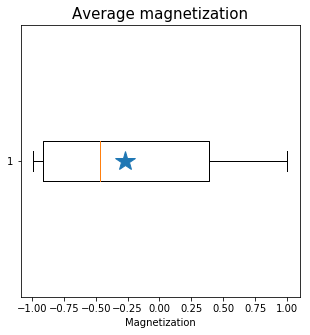

In [24]:
fig1, (ax1) = plt.subplots(figsize=(5, 5))

ax1.boxplot(magn_sper, vert = False)

ax1.plot( avg_config, 1, marker='*', markersize=20 )

ax1.set_title('Average magnetization', fontsize=15)

ax1.set_xlabel('Magnetization')
plt.show()

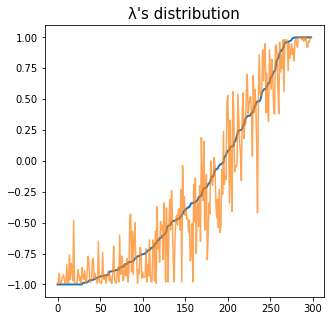

In [25]:
fig1, (ax1) = plt.subplots(figsize=(5, 5))

my_config = np.array(metropolis_sample(mean_λ_0, mean_K)[0])

ax1.plot(np.sort(np.mean(my_config ,axis=0) ) , linewidth=2)

ax1.plot(magn_sper[np.argsort(np.mean(my_config, axis=0))], alpha=0.7)

ax1.set_title('λ\'s distribution', fontsize=15)
            
plt.show()

## Task 5

In [26]:
µ_λ = np.mean(mean_λ_0)
σ_λ = np.std(mean_λ_0)

print("The average of λ is:\t", µ_λ)
print("The σ of λ is:\t\t", σ_λ)

print("The compatibility of the avg of λ with 0 is:\n", np.abs(0-µ_λ)/σ_λ)

The average of λ is:	 0.0902015561771032
The σ of λ is:		 1.1501022993579952
The compatibility of the avg of λ with 0 is:
 0.07842915906476762


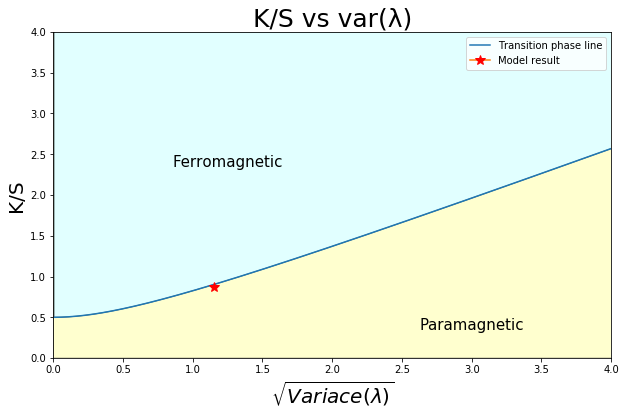

In [34]:
import scipy.integrate

# testing parameter β
β = 1
#σ=1
def phase_curve(h,σ):
    return (np.exp(-0.5*(h)**2/((σ)**2)) / (((np.cosh(h*β))**2) *β* np.sqrt(2*np.pi*(σ)**2)))

x_values = []
x_interv = np.linspace(0.001, 5, 1000)


for i in x_interv:
    integral_ = scipy.integrate.quad(phase_curve, -10, 10, args=(i) )
    x_values.append(0.5/(integral_[0]))

plt.figure(figsize=(10, 6))
plt.plot(x_interv[1:], x_values[1:], label="Transition phase line")
#plt.plot( x_values, x_interv)
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.title('K/S vs var(λ)', fontsize=25)
plt.xlabel(r"$\sqrt{Variace(λ)}$", fontsize=20)
plt.ylabel("K/S", fontsize=20)
plt.fill_between(x_interv, 0, x_values, alpha=0.35, edgecolor="#000000", facecolor="#ffff77")
plt.fill_between(x_interv,  x_values,4, alpha=0.35, edgecolor="#000000", facecolor="#aaffff")
plt.plot(σ_λ, K, marker = '*', ms=11, markeredgecolor="#ff0000", markerfacecolor="#ff0000", label="Model result")
plt.text(3, 0.5, "Paramagnetic", ha="center", color="#000000", va="top", fontsize=15)
plt.text(1.25, 2.5, "Ferromagnetic", ha="center", color="#000000", va="top", fontsize=15)
plt.legend()
plt.show()

## Task 6

In [35]:
vectors_np=np.array(vectors)
std=np.std(vectors_np, axis=1)
mean=np.mean(vectors_np, axis=1)


newvectors=vectors[mean>std]

# to see the dataframe uncomment the following line
#newvectors

In [36]:
new_mean=np.array(newvectors.mean(axis=1))
M_inv=newvectors.T.cov()
M=np.linalg.inv(M_inv)
#M=np.linalg.inv(M) #se voglio usare M_inv al posto di M

for i in range(len(M)):
    M[i][i]=0

# to show M uncomment the following line
#pd.DataFrame(M)

In [38]:
µ=-M.dot(new_mean)
pd.DataFrame(µ).rename(index=str, columns={0:'$\mu$'})

0.3231133528604275


,$\mu$
0,0.152135
1,0.139548
2,0.567857
3,0.171238
4,0.581489
5,0.897921
6,0.447018
7,0.210770
8,0.096871
9,0.357246


In [46]:
# uncomment to place the complete matrix into a file
#nome_file="Personalizza.csv"
#pd.DataFrame(M).to_csv(nome_file, index=False, header=False, sep="\t")

## Task 7

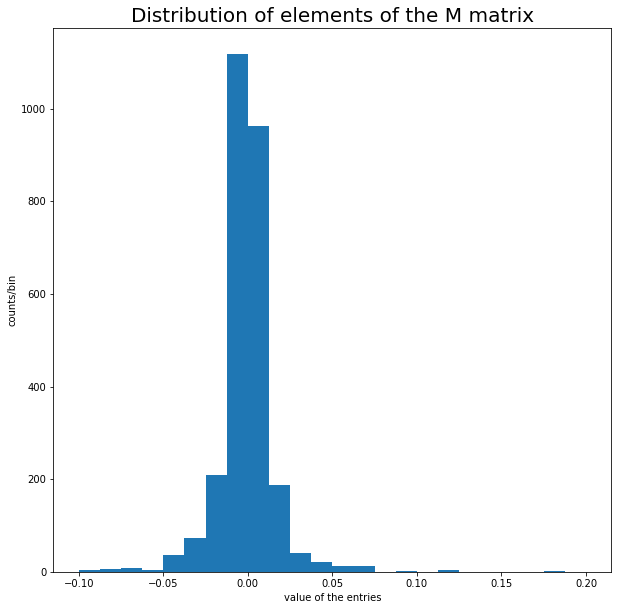

In [52]:
plt.figure(figsize=(10,10))
bins = np.linspace(-0.10, 0.20, 25)
plt.hist(M.reshape(2704), bins=bins)
plt.title('Distribution of elements of the M matrix', fontsize=20)
plt.ylabel('counts/bin')
plt.xlabel('value of the entries')

plt.show()

In [57]:
M_threshold=M.copy()


theta=[i/5000 for i in range(0,500)]  #se voglio usare M_inv al posto di M
#theta=[i for i in range(0,500)]
components=[]
connect=[]

for i in theta:
    
    M_threshold[np.abs(M_threshold)<i]=0
    G=nx.from_numpy_matrix(M_threshold)
    components.append(nx.number_connected_components(G))
    connect.append(nx.is_connected(G))
    
for i in range(len(components)-1):
    if ((components[i]==1)&(components[i+1]==2)):
        threshold=theta[i]
        print('the best threshold is:',threshold)

the best threshold is: 0.003


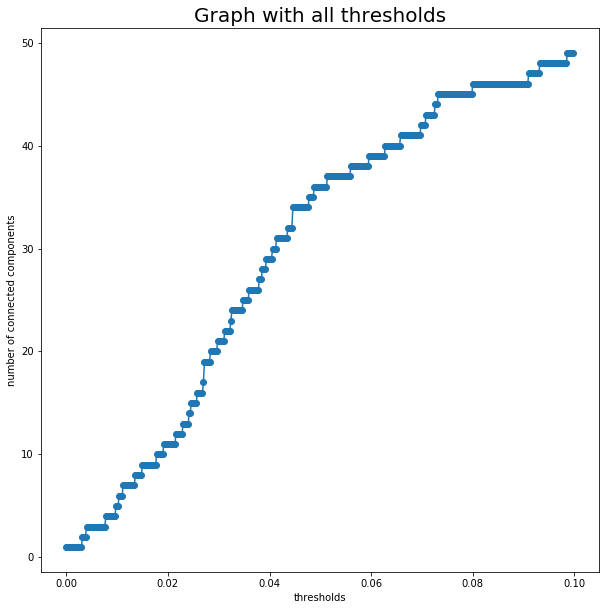

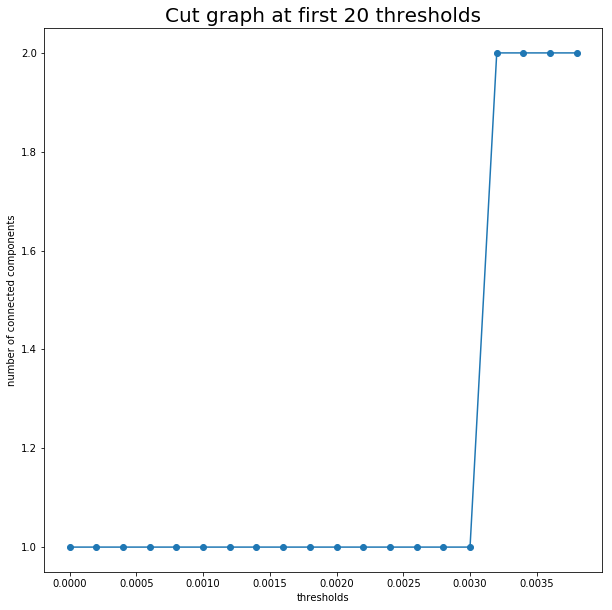

In [58]:
 plt.figure(figsize=(10,10))
plt.title("Graph with all thresholds", fontsize = 20)
plt.plot(np.array(theta), components, '-o')
plt.ylabel('number of connected components')
plt.xlabel('thresholds')

plt.show()

plt.figure(figsize=(10,10))
plt.title("Cut graph at first 20 thresholds", fontsize = 20)
plt.plot(np.array(theta)[:20], components[:20], '-o')
plt.ylabel('number of connected components')
plt.xlabel('thresholds')

plt.show()

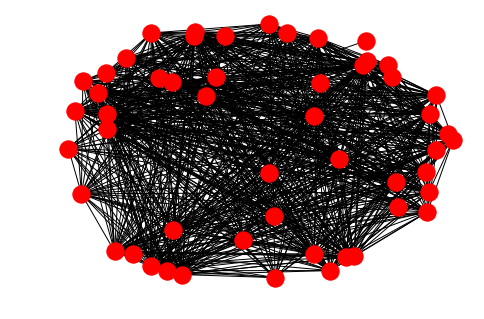

In [59]:
M_final=M.copy()
M_final[np.abs(M_final)<threshold]=0
G=nx.from_numpy_matrix(M_final)
nx.draw(G)
plt.show()

In [60]:
print('the diameter of the graph is:',nx.diameter(G))
print('the clustering coefficient is:',nx.transitivity(G))
print('the assortativity coefficient is:',nx.degree_assortativity_coefficient(G))
s=pd.Series(nx.betweenness_centrality(G), name='betweeness centrality')
s=s.reset_index()
s.drop('index', axis=1, inplace=True)  
s.rename_axis("node", inplace=True)

# uncomment to print s
#print("\n\n",s)

the diameter of the graph is: 3
the clustering coefficient is: 0.710638456937799
the assortativity coefficient is: -0.23291032672420972


In [61]:
# Erdos Renyi graph
diameter=0
trans=0
assort=0
betweeness=np.zeros(52)
number_generated_graphs=100
p=np.count_nonzero(M_final)/(len(M_final)*(len(M_final)-1))

diameter=[]
trans=[]
assort=[]
seq_ER=[]


for i in range(number_generated_graphs):
    ER=nx.erdos_renyi_graph(52,p )
    diameter.append(nx.diameter(ER))
    trans.append(nx.transitivity(ER))
    assort.append(nx.degree_assortativity_coefficient(ER))
    betweeness+=np.fromiter(nx.betweenness_centrality(ER).values(), dtype=np.float)
    seq_ER.append(ER.degree())

diameter=np.array(diameter)
trans=np.array(trans)
assort=np.array(assort)

print('the average diameter of the ensamble of random graph is:',diameter.mean(), '±', diameter.std())
print('the average clustering coefficient of the ensamble of random graph is:',trans.mean() , '±', trans.std())
print('the average assortativity coefficient of the ensamble of random graph is:',assort.mean(), '±', assort.std())

s1=pd.Series(betweeness/number_generated_graphs, name='betweeness centrality')
s1=s1.reset_index()
s1.drop('index', axis=1, inplace=True)  
s1.rename_axis("node", inplace=True)

#print("\n\n", s1)

the average diameter of the ensamble of random graph is: 2.0 ± 0.0
the average clustering coefficient of the ensamble of random graph is: 0.6062399148456521 ± 0.014047284875414729
the average assortativity coefficient of the ensamble of random graph is: -0.043335816682186945 ± 0.02455243539922677


In [ ]:
# here we print the average betweenes centrality
print("The betweenes centrality of our graph is:", np.array(s).mean())
print("The betweenes centrality of E-R ensemble is:",np.array(s1).mean())

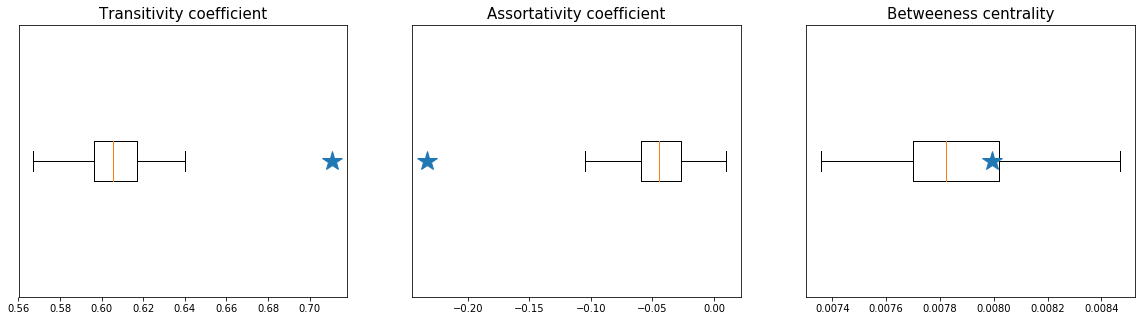

In [123]:
fig1, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 5))


ax1.boxplot(trans, vert = False)
ax2.boxplot( assort, vert = False)
ax3.boxplot( np.array(s1), vert = False)
ax1.plot( nx.transitivity(G), 1, marker='*', markersize=20 )
ax2.plot(  nx.degree_assortativity_coefficient(G), 1, marker='*', markersize=20 )
ax3.plot(  np.array(s).mean(), 1, marker='*', markersize=20 )
ax1.set_title('Transitivity coefficient', fontsize=15)
ax2.set_title('Assortativity coefficient', fontsize=15)
ax3.set_title('Betweeness centrality', fontsize=15)
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])

plt.show()

In [64]:
from math import factorial as fac

def binomial(x, y):
    try:
        binom = fac(x) // fac(y) // fac(x - y)
    except ValueError:
        binom = 0
    return binom

k=np.arange(52)

kbin=np.zeros(52)
for i in k:
    kbin[i]=binomial(51,k[i])

In [ ]:
import collections

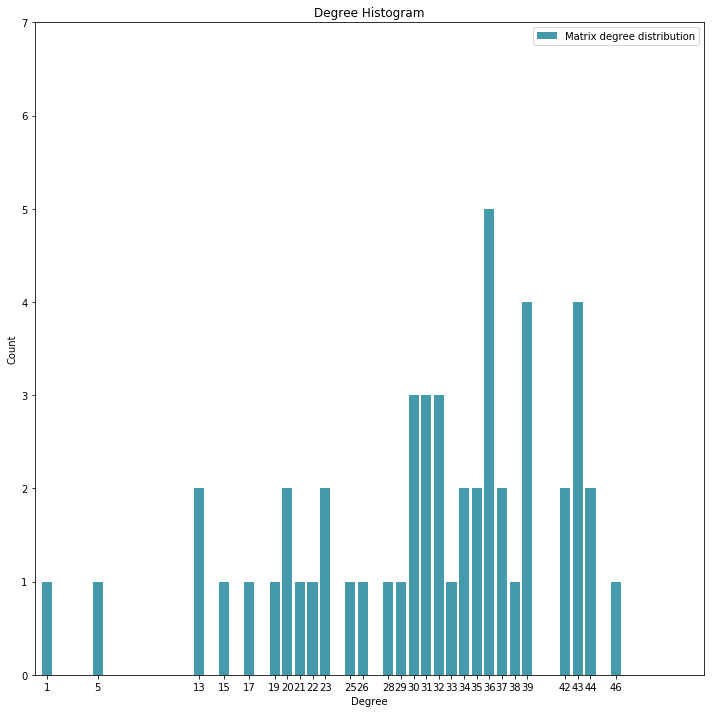

In [75]:
#distribuzione degree del nostro grafo

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
#print ("Degree sequence", degree_sequence)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize=(12,12))
plt.bar(deg, cnt, width=0.80, color='#4499aa', label='Matrix degree distribution')

plt.ylim(0, 7)
plt.xlim(0, 53)
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d for d in deg])
ax.set_xticklabels(deg)
plt.legend()
plt.show()

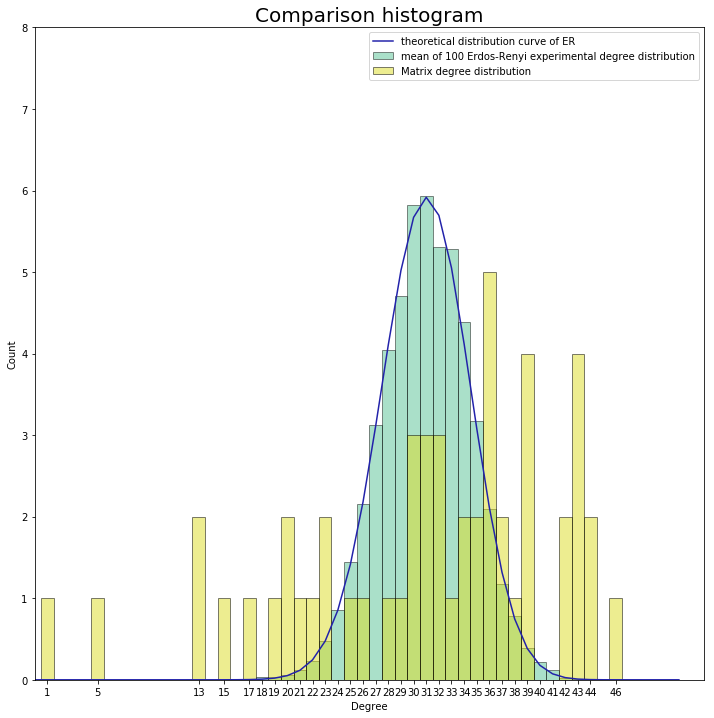

In [116]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
#print ("Degree sequence", degree_sequence)
degreeCount = collections.Counter(degree_sequence)
deg1, cnt1 = zip(*degreeCount.items())

#distribuzione media dei degree di 100 ER


degreeCount_array=np.zeros((0))
df=[]

for i in range(number_generated_graphs):

    degree_sequence = sorted([d for n, d in seq_ER[i]], reverse=True)  # degree sequence
    #print ("Degree sequence", degree_sequence)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    df.append(pd.DataFrame(pd.Series(pd.Series(data=cnt,index=deg))))

    
dff=reduce(lambda x, y: pd.DataFrame.join(x,y, how='outer', lsuffix='_left', rsuffix='_right').fillna(0), df)
meandegree=dff.mean(axis=1)


fig, ax = plt.subplots(figsize=(12,12))
plt.bar(np.array(meandegree.index), np.array(meandegree.values), width=1.0, edgecolor = 'k', alpha=0.45, color='#44bb88', label='mean of 100 Erdos-Renyi experimental degree distribution')
plt.bar(deg1, cnt1, width=1.0, color='#dddd22', edgecolor='k', label='Matrix degree distribution', alpha=0.5)
plt.plot(k,52*kbin*p**k*(1-p)**(51-k), c='#2222aa', label='theoretical distribution curve of ER')

# preparing ticks altoghether
tick1 = np.array(meandegree.index)
tick2 = np.array(deg1)
tick = np.concatenate( (tick1, tick2), axis = None)
tick = np.unique(tick)

plt.ylim(0, 8)
plt.xlim(0, 53)
plt.title("Comparison histogram", fontsize = 20)
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d for d in tick])
ax.set_xticklabels(tick)
plt.legend()
plt.show()

In [127]:
p

0.60633